# Notebook 3: The Simulation Environment

In this notebook, we'll take a deep dive into our simulation environment. Understanding the environment interface is crucial for RL - it's what your agent will interact with!

## What You'll Learn

1. The environment API (reset, step, etc.)
2. How to customize environment parameters
3. Understanding rewards and termination
4. Collecting and storing episode data
5. Visualizing episodes

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from src.environments import InvertedPendulumEnv
from src.utils import plot_trajectory, animate_pendulum

## 1. The Environment API

Our environment follows the standard RL environment interface (similar to OpenAI Gym):

### Key Methods

| Method | Description | Returns |
|--------|-------------|--------|
| `reset()` | Start a new episode | Initial state |
| `step(action)` | Take one action | (state, reward, done, info) |
| `get_history()` | Get episode data | Dict of arrays |

This is the interface you'll use in all RL algorithms!

In [2]:
# Create an environment
env = InvertedPendulumEnv()

# See what's inside
print("Environment Parameters:")
print(f"  Gravity: {env.gravity} m/s²")
print(f"  Cart mass: {env.cart_mass} kg")
print(f"  Pole mass: {env.pole_mass} kg")
print(f"  Pole length: {env.pole_length} m (half-length)")
print(f"  Max force: {env.force_mag} N")
print(f"  Time step: {env.tau} s")
print(f"  Max steps: {env.max_steps}")
print(f"\nTermination thresholds:")
print(f"  Angle: ±{np.degrees(env.theta_threshold):.1f}°")
print(f"  Position: ±{env.x_threshold} m")

Environment Parameters:
  Gravity: 9.81 m/s²
  Cart mass: 1.0 kg
  Pole mass: 0.1 kg
  Pole length: 0.5 m (half-length)
  Max force: 10.0 N
  Time step: 0.02 s
  Max steps: 500

Termination thresholds:
  Angle: ±12.0°
  Position: ±2.4 m


In [3]:
# Reset the environment
state = env.reset(seed=42)

print("After reset():")
print(f"  State: {state}")
print(f"  State shape: {state.shape}")
print(f"\n  [x, x_dot, theta, theta_dot]")
print(f"  Position: {state[0]:.4f} m")
print(f"  Velocity: {state[1]:.4f} m/s")
print(f"  Angle: {np.degrees(state[2]):.2f}°")
print(f"  Angular vel: {state[3]:.4f} rad/s")

After reset():
  State: [-0.01254599  0.04507143  0.02319939  0.00986585]
  State shape: (4,)

  [x, x_dot, theta, theta_dot]
  Position: -0.0125 m
  Velocity: 0.0451 m/s
  Angle: 1.33°
  Angular vel: 0.0099 rad/s


In [4]:
# Take a step
action = 5.0  # Push right with 5 Newtons
next_state, reward, done, info = env.step(action)

print(f"After step(action={action}):")
print(f"\n  Next state: {next_state}")
print(f"  Reward: {reward}")
print(f"  Done: {done}")
print(f"\n  Info dict:")
for key, value in info.items():
    print(f"    {key}: {value}")

After step(action=5.0):

  Next state: [-0.01164456  0.14229565  0.02339671 -0.12910426]
  Reward: 1.0
  Done: False

  Info dict:
    x: -0.011644559502443919
    x_dot: 0.1422956470416767
    theta: 0.023396711149534576
    theta_dot: -0.129104263243133
    force: 5.0
    steps: 1
    terminated_by_angle: False
    terminated_by_position: False
    terminated_by_time: False


## 2. Customizing the Environment

You can modify the physics parameters to create different challenges!

In [5]:
# Easy environment (longer pole = easier to balance)
easy_env = InvertedPendulumEnv(
    pole_length=1.0,  # Longer pole
    theta_threshold=0.4,  # More forgiving angle
    max_steps=1000
)

# Hard environment
hard_env = InvertedPendulumEnv(
    pole_length=0.25,  # Shorter pole
    theta_threshold=0.1,  # Strict angle requirement
    force_mag=5.0,  # Less force available
    max_steps=500
)

# Moon environment!
moon_env = InvertedPendulumEnv(
    gravity=1.62,  # Moon gravity
    max_steps=500
)

print("Created three custom environments!")
print(f"Easy: pole_length={easy_env.pole_length}m")
print(f"Hard: pole_length={hard_env.pole_length}m")
print(f"Moon: gravity={moon_env.gravity}m/s²")

Created three custom environments!
Easy: pole_length=1.0m
Hard: pole_length=0.25m
Moon: gravity=1.62m/s²


In [6]:
# Compare how long each balances with same initial condition and no control
envs = [
    (easy_env, "Easy (long pole)"),
    (env, "Default"),
    (hard_env, "Hard (short pole)"),
    (moon_env, "Moon gravity")
]

initial_state = [0, 0, 0.05, 0]

print("Steps to fall with no control (from θ=0.05 rad):\n")
for e, name in envs:
    e.reset(initial_state=initial_state)
    done = False
    while not done:
        _, _, done, _ = e.step(0)
    print(f"  {name}: {e.steps} steps")

Steps to fall with no control (from θ=0.05 rad):

  Easy (long pole): 16 steps
  Default: 8 steps
  Hard (short pole): 5 steps
  Moon gravity: 8 steps


## 3. Understanding Rewards

The reward function defines what we want the agent to achieve:

### Current Reward Function
- **+1** for each step the pole stays balanced
- **0** when episode terminates

This encourages the agent to keep the pole balanced as long as possible!

### Alternative Reward Functions
You could design different rewards:
- Penalize large angles
- Penalize large velocities
- Penalize control effort (energy efficiency)

In [7]:
# Run an episode and track rewards
env = InvertedPendulumEnv()
state = env.reset(seed=123)

# Simple proportional control
rewards = []
done = False

while not done:
    # Simple control: push in direction of lean
    theta = state[2]
    action = 10 * theta + 2 * state[3]  # PD control
    
    state, reward, done, info = env.step(action)
    rewards.append(reward)

print(f"Episode length: {len(rewards)} steps")
print(f"Total reward: {sum(rewards)}")
print(f"\nTermination reason:")
if info['terminated_by_time']:
    print("  Success! Reached maximum steps.")
else:
    print("  Failed - pole fell or cart off track")

Episode length: 181 steps
Total reward: 180.0

Termination reason:
  Failed - pole fell or cart off track


## 4. Collecting Episode Data

For learning and visualization, we need to record what happened during an episode.

In [8]:
# The environment automatically records history
env = InvertedPendulumEnv()
state = env.reset(seed=456)

# Run episode with simple control
done = False
while not done:
    action = 8 * state[2] + 1.5 * state[3]
    state, _, done, _ = env.step(action)

# Get the history
history = env.get_history()

print("Episode history:")
print(f"  States shape: {history['states'].shape}")
print(f"  Actions shape: {history['actions'].shape}")
print(f"  Rewards shape: {history['rewards'].shape}")

print(f"\nFirst 5 states:")
print(history['states'][:5])

print(f"\nFirst 5 actions:")
print(history['actions'][:5])

Episode history:
  States shape: (86, 4)
  Actions shape: (85,)
  Rewards shape: (85,)

First 5 states:
[[-0.02512441 -0.03369332  0.02836433  0.03085234]
 [-0.02579828 -0.02876997  0.02898137  0.03181678]
 [-0.02637367 -0.02373093  0.02961771  0.03278943]
 [-0.02684829 -0.01857324  0.0302735   0.03377149]
 [-0.02721976 -0.01329385  0.03094893  0.03476417]]

First 5 actions:
[0.27319311 0.27957616 0.2861258  0.29284521 0.29973766]


## 5. Visualizing Episodes

Let's use our visualization tools to understand what's happening!

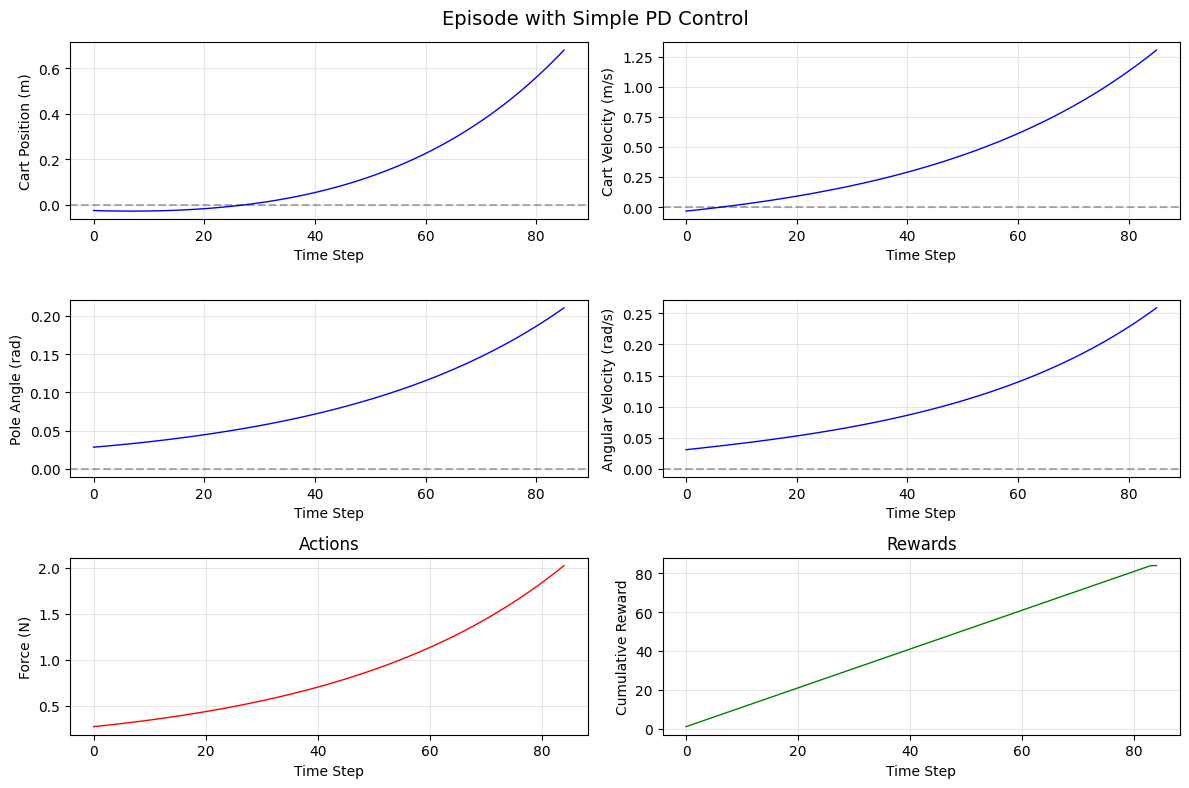

In [9]:
# Plot the trajectory
fig = plot_trajectory(history, title="Episode with Simple PD Control")
plt.show()

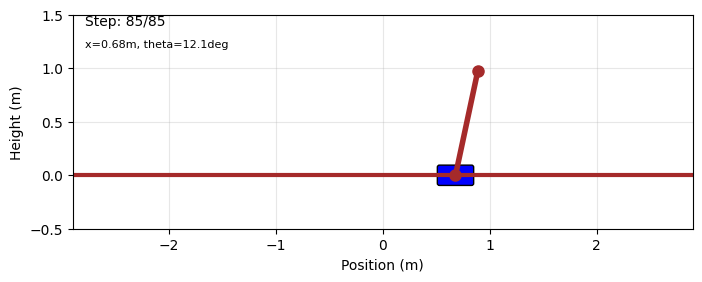

In [10]:
# Animate the episode (this creates an animation object)
# Note: Animation display depends on your Jupyter setup
from IPython.display import HTML

env_params = {
    'pole_length': env.pole_length,
    'x_threshold': env.x_threshold
}

anim = animate_pendulum(history, env_params, interval=50)
HTML(anim.to_jshtml())

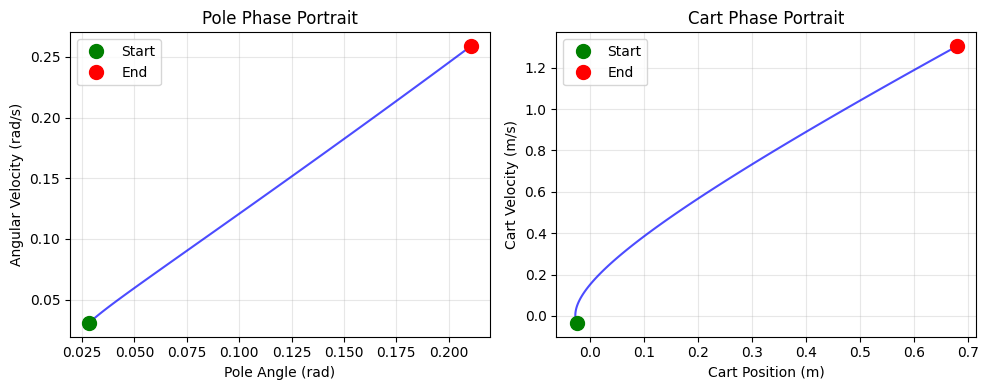

In [11]:
# Let's also look at the phase portrait
from src.utils.visualization import plot_phase_portrait

fig = plot_phase_portrait(history)
plt.show()

## 6. Putting It All Together

Here's a complete example of running multiple episodes and collecting statistics:

In [12]:
def run_episode(env, control_fn, seed=None):
    """Run one episode with a given control function."""
    state = env.reset(seed=seed)
    total_reward = 0
    done = False
    
    while not done:
        action = control_fn(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
    
    return total_reward, env.get_history(), info

# Define different control strategies
def no_control(state):
    return 0

def random_control(state):
    return np.random.uniform(-10, 10)

def proportional_control(state):
    return 10 * state[2]  # P control

def pd_control(state):
    return 10 * state[2] + 3 * state[3]  # PD control

# Compare strategies
env = InvertedPendulumEnv()
n_episodes = 20

strategies = [
    (no_control, "No Control"),
    (random_control, "Random"),
    (proportional_control, "P Control"),
    (pd_control, "PD Control")
]

print(f"Average reward over {n_episodes} episodes:\n")

for control_fn, name in strategies:
    rewards = []
    for i in range(n_episodes):
        reward, _, _ = run_episode(env, control_fn, seed=i)
        rewards.append(reward)
    
    print(f"  {name:15s}: {np.mean(rewards):6.1f} ± {np.std(rewards):5.1f}")

Average reward over 20 episodes:

  No Control     :    8.3 ±   0.8
  Random         :   26.6 ±   8.8
  P Control      :  134.8 ±  48.3
  PD Control     :  240.6 ± 113.2


## Exercises

### Exercise 1: Custom Environment
Create a "Jupiter" environment with high gravity (24.79 m/s²) and test how well PD control works.

### Exercise 2: Custom Reward
Modify the episode runner to compute a custom reward that penalizes large angles.

### Exercise 3: Find Good Control Gains
Experiment with different values for the P and D gains in PD control. Can you find values that work better?

In [13]:
# Exercise 3: Experiment with PD gains
def make_pd_controller(kp, kd):
    """Create a PD controller with given gains."""
    def controller(state):
        return kp * state[2] + kd * state[3]
    return controller

# Try different gain combinations
env = InvertedPendulumEnv()
gain_pairs = [
    (5, 1), (10, 1), (10, 3), (10, 5),
    (15, 3), (20, 5), (20, 10)
]

print("Testing different PD gains (Kp, Kd):\n")

best_reward = 0
best_gains = None

for kp, kd in gain_pairs:
    controller = make_pd_controller(kp, kd)
    rewards = []
    
    for i in range(10):
        reward, _, _ = run_episode(env, controller, seed=i)
        rewards.append(reward)
    
    mean_reward = np.mean(rewards)
    print(f"  Kp={kp:2d}, Kd={kd:2d}: {mean_reward:6.1f}")
    
    if mean_reward > best_reward:
        best_reward = mean_reward
        best_gains = (kp, kd)

print(f"\nBest gains: Kp={best_gains[0]}, Kd={best_gains[1]}")

Testing different PD gains (Kp, Kd):

  Kp= 5, Kd= 1:   74.8
  Kp=10, Kd= 1:  211.5
  Kp=10, Kd= 3:  254.3
  Kp=10, Kd= 5:  270.8
  Kp=15, Kd= 3:  455.5
  Kp=20, Kd= 5:  485.8
  Kp=20, Kd=10:  433.5

Best gains: Kp=20, Kd=5


## Summary

In this notebook, we learned:

- **Environment API**: `reset()`, `step()`, `get_history()`
- **Customization**: Modify physics parameters for different challenges
- **Rewards**: +1 per step encourages balancing
- **Data collection**: The environment records states, actions, rewards
- **Visualization**: Plot trajectories and animate episodes

## Next Steps

Now that we understand the environment, let's learn about **policies** - the agent's decision-making strategy!